In [1]:
import os
import numpy as np
import scipy.io
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import h5py
import os
import cv2

data_dir = "/kaggle/input/figshare-brain-tumor-dataset/dataset/data"
total_images = 3064  

X_tumor = []
Y_tumor_mask = []
tumour_labels = []  # Store labels in a list

for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    
    # Open file safely
    with h5py.File(os.path.join(data_dir, filename), "r") as data:
        
        # Extract tumor image
        image = np.array(data["cjdata"]["image"], dtype=np.float32)
        image = cv2.resize(image, (128, 128))  # Resize for U-Net input
        image = image / 255.0  # Normalize pixel values
        X_tumor.append(image)

        # Extract tumor mask
        mask = np.array(data["cjdata"]["tumorMask"], dtype=np.uint8)  # Get segmentation mask
        mask = cv2.resize(mask, (128, 128))
        mask = (mask > 0).astype(np.uint8)  # Convert to binary mask (0 or 1)
        Y_tumor_mask.append(mask)

        # Extract tumor label (1: Meningioma, 2: Glioma, 3: Pituitary Tumor)
        label = int(np.array(data["cjdata"]["label"])[0][0])  # Ensure integer type
        tumour_labels.append(label)  # Append label to list

# Convert lists to numpy arrays
X_tumor = np.array(X_tumor).reshape(-1, 128, 128, 1)  # Add channel dimension
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 128, 128, 1)  # Segmentation masks
tumour_labels = np.array(tumour_labels)  # Convert to NumPy array

print("Dataset Shapes:")
print("X_tumor:", X_tumor.shape)  # (N, 128,128, 1)
print("Y_tumor_mask:", Y_tumor_mask.shape)  # (N, 128,128, 1)
print("Tumor Labels:", tumour_labels.shape)  # (N,)
print("Unique Labels:", np.unique(tumour_labels))  # Check unique labels


Dataset Shapes:
X_tumor: (3064, 128, 128, 1)
Y_tumor_mask: (3064, 128, 128, 1)
Tumor Labels: (3064,)
Unique Labels: [1 2 3]


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# Apply label mapping before splitting
label_mapping = {1: 0, 2: 1, 3: 2}
mapped_labels = np.array([label_mapping[label] for label in tumour_labels])

# Step 1: Split into Train (80%) and Temp (20%)
X_train, X_temp, Y_train_mask, Y_temp_mask, Y_train_labels, Y_temp_labels = train_test_split(
    X_tumor, Y_tumor_mask, mapped_labels, test_size=0.3, random_state=42, stratify=mapped_labels
)

# Step 2: Split Temp into Validation (10%) and Test (10%)
X_val, X_test, Y_val_mask, Y_test_mask, Y_val_labels, Y_test_labels = train_test_split(
    X_temp, Y_temp_mask, Y_temp_labels, test_size=0.5, random_state=42, stratify=Y_temp_labels
)

# Compute Segmented MRI Images (Element-wise Multiplication)
X_train_seg = X_train * Y_train_mask
X_val_seg = X_val * Y_val_mask
X_test_seg = X_test * Y_test_mask

# Print dataset shapes
print("Shapes:")
print("Train:", X_train.shape, Y_train_mask.shape)
print("Validation:", X_val.shape, Y_val_mask.shape)
print("Test:", X_test.shape, Y_test_mask.shape)

# Compute new label distributions
unique_labels, label_counts = np.unique(mapped_labels, return_counts=True)

# Define new class names
class_mapping = {
    0: "Meningioma",
    1: "Glioma",
    2: "Pituitary",
}

# Print class distribution after remapping
print("\nClass Distribution after Remapping:")
for label, count in zip(unique_labels, label_counts):
    print(f"{class_mapping[label]} (Label {label}): {count} samples")


Shapes:
Train: (2144, 128, 128, 1) (2144, 128, 128, 1)
Validation: (460, 128, 128, 1) (460, 128, 128, 1)
Test: (460, 128, 128, 1) (460, 128, 128, 1)

Class Distribution after Remapping:
Meningioma (Label 0): 708 samples
Glioma (Label 1): 1426 samples
Pituitary (Label 2): 930 samples


In [4]:
import tensorflow as tf
import numpy as np
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
import cv2

# Define image size
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
TARGET_SIZE = 6000  # Desired augmented dataset size

# Albumentations Augmentation Pipeline
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),  # Random Rotation (-30 to +30 degrees)
    #A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.5),
    #A.GaussianBlur(p=0.2),  # Apply slight blur
    #A.GaussNoise(p=0.2),  # Add noise
    #A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),  # Elastic deformation (for MRI)
    A.Resize(128, 128),  # Ensure size remains consistent
])

def augment_images(mri, seg):
    """Applies Albumentations transformations to both MRI and segmented MRI images."""

    def apply_albumentations(mri_img, seg_img):
        """Convert images to NumPy, apply Albumentations, and return augmented images."""
        mri_img = mri_img.numpy()
        seg_img = seg_img.numpy()

        # Apply the same transformations to both MRI and mask
        augmented = albumentations_transform(image=mri_img, mask=seg_img)
        mri_aug = augmented["image"]
        seg_aug = augmented["mask"]

        return mri_aug, seg_aug

    # Apply using tf.py_function
    mri, seg = tf.py_function(func=apply_albumentations, inp=[mri, seg], Tout=[tf.float32, tf.float32])

    # Ensure correct shape after augmentation
    mri.set_shape((128, 128, 1))
    seg.set_shape((128, 128, 1))

    return mri, seg

# Function to process dataset (Augmentation + Compute Segmented Image)
def process_data(mri, seg, label):
    """Applies augmentation and ensures correct format for model input."""
    mri_aug, seg_aug = augment_images(mri, seg)
    return (mri_aug, seg_aug), label  # Model expects ((MRI, Seg), Label)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train_seg, Y_train_labels))

# Repeat dataset to increase size
num_repeats = TARGET_SIZE // len(X_train)  
train_dataset = train_dataset.repeat(num_repeats).map(process_data, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, Batch, and Prefetch
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


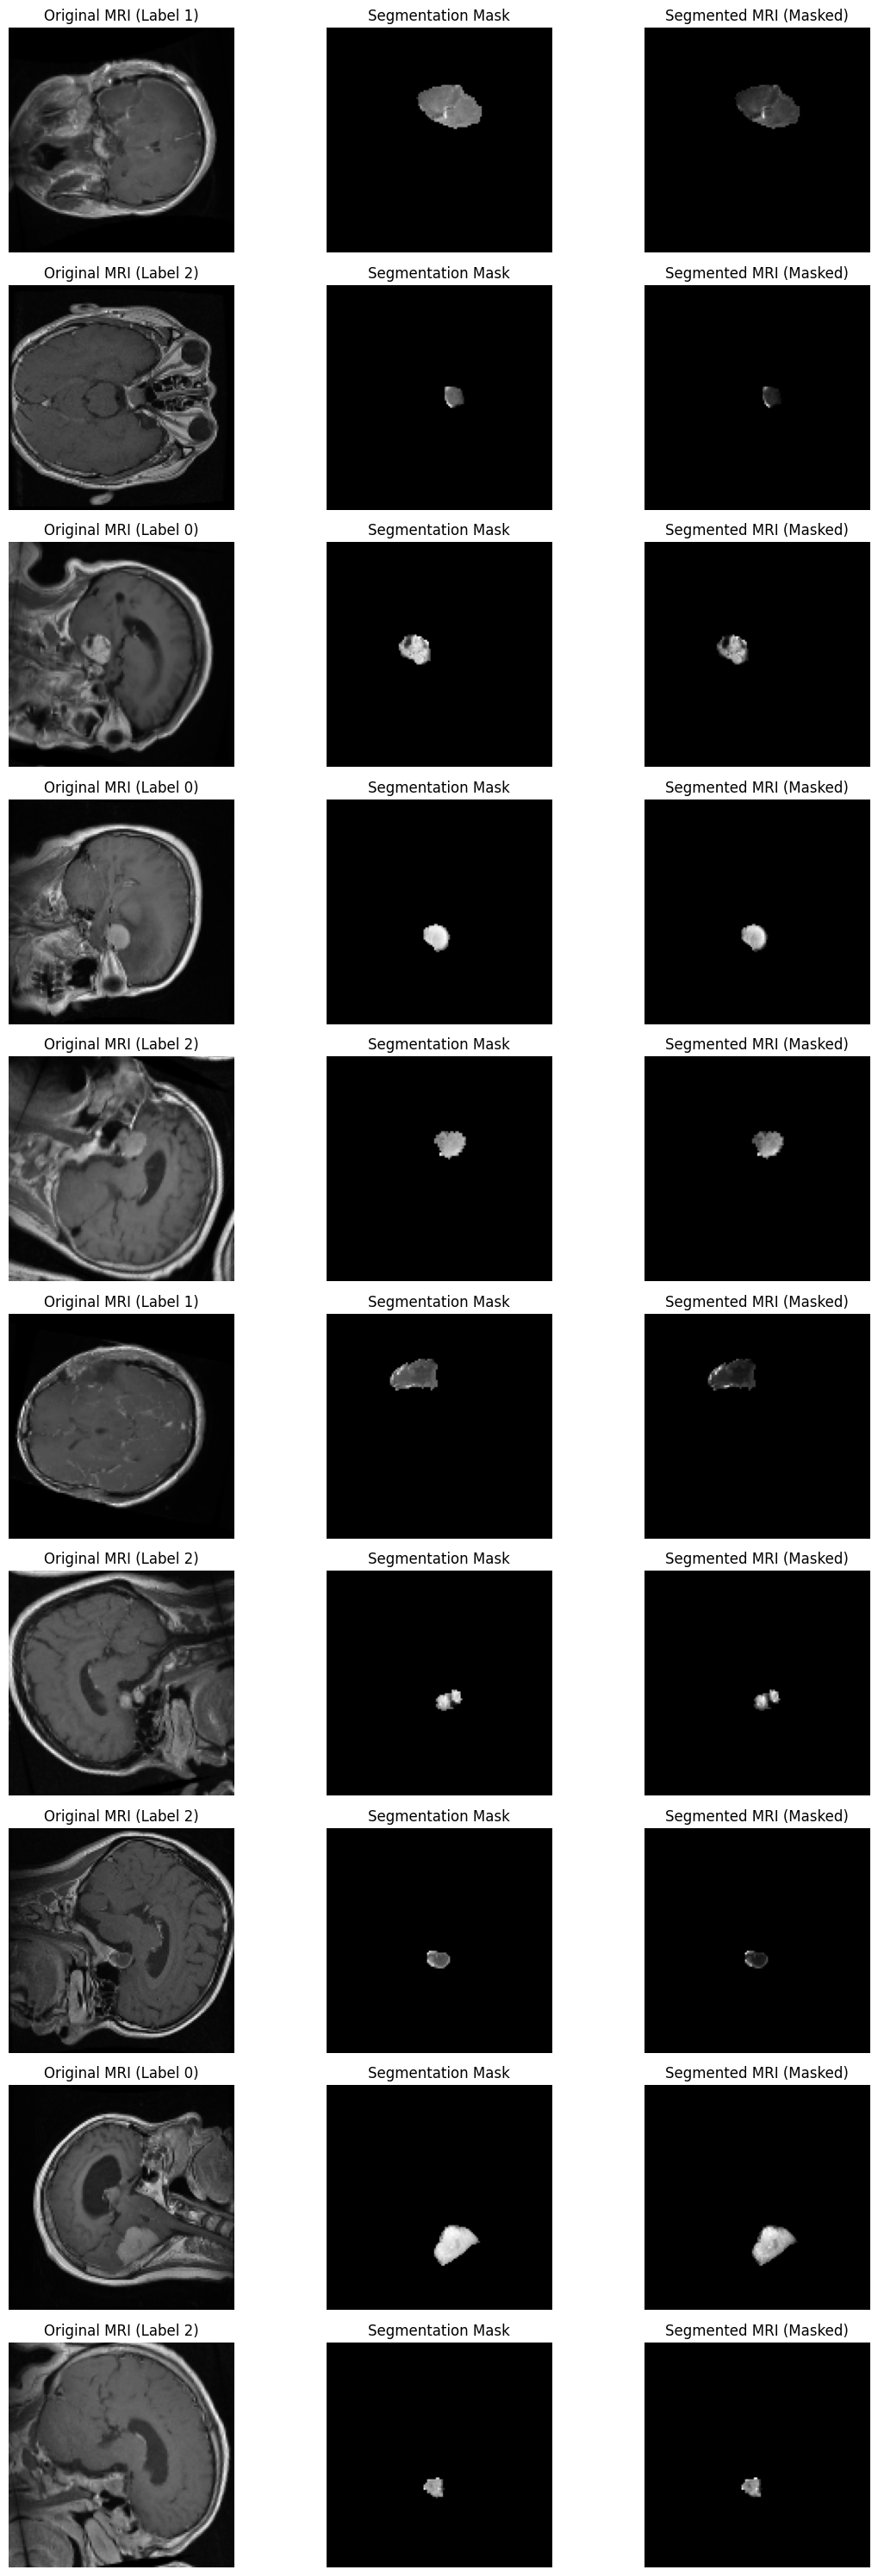

In [5]:
import matplotlib.pyplot as plt

# Function to display images
def show_sample_images(dataset, num_samples=10):
    """Displays a batch of images: Original MRI, Mask, and Segmented MRI."""

    # Extract one batch from dataset
    for (mri, mask), label in dataset.take(1):  # Unpack dataset properly
        mri = mri.numpy()  # Convert to NumPy
        mask = mask.numpy()  # Convert to NumPy
        seg_mri = mri * mask  # Compute segmented MRI

        # Show first `num_samples` images
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
        for i in range(num_samples):
            # Original MRI
            axes[i, 0].imshow(mri[i].squeeze(), cmap="gray")
            axes[i, 0].set_title(f"Original MRI (Label {label[i]})")
            axes[i, 0].axis("off")

            # Segmentation Mask
            axes[i, 1].imshow(mask[i].squeeze(), cmap="gray")
            axes[i, 1].set_title("Segmentation Mask")
            axes[i, 1].axis("off")

            # Segmented MRI (MRI × Mask)
            axes[i, 2].imshow(seg_mri[i].squeeze(), cmap="gray")
            axes[i, 2].set_title("Segmented MRI (Masked)")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.show()
        break  # Stop after one batch

# Call function to visualize training images
show_sample_images(train_dataset)


In [6]:
batch_size = 32  # Your batch size
num_batches = sum(1 for _ in train_dataset)  # Number of batches
total_images = num_batches * batch_size
print("Total Training Images (Estimated):", total_images)


Total Training Images (Estimated): 4288


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Lambda
from tensorflow.keras.models import Model

# Function to Convert 1-Channel to 3-Channel (Required for ResNet & DenseNet)
def grayscale_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# Input 1: Full MRI Image (Convert Grayscale to RGB)
input_mri = Input(shape=(128, 128, 1), name="Full_MRI")
mri_rgb = Lambda(grayscale_to_rgb)(input_mri)  # Convert grayscale to 3-channel
resnet = ResNet50(include_top=False, weights=None, input_shape=(128, 128, 3))
resnet_features = Flatten()(resnet(mri_rgb))

# Input 2: Segmented MRI Image (Convert Grayscale to RGB)
input_seg = Input(shape=(128, 128, 1), name="Segmented_MRI")
seg_rgb = Lambda(grayscale_to_rgb)(input_seg)  # Convert grayscale to 3-channel
densenet = DenseNet121(include_top=False, weights=None, input_shape=(128, 128, 3))
densenet_features = Flatten()(densenet(seg_rgb))

# Concatenate Both Feature Maps
merged_features = Concatenate()([resnet_features, densenet_features])

# Fully Connected Layers
x = Dense(512, activation="relu")(merged_features)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output Layer (Tumor Classification)
output = Dense(3, activation="softmax", name="Tumor_Classification")(x)  # 3 classes: Meningioma, Glioma, Pituitary

# Define Model
model = Model(inputs=[input_mri, input_seg], outputs=output)

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Full_MRI (InputLayer)     │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Segmented_MRI             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 3)    │              0 │ Full_MRI[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128, 128, 3)    │              0 │ Segmented_MRI[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 4, 4, 2048)     │     23,587,712 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 4, 4, 1024)     │      7,037,504 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32768)          │              0 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 16384)          │              0 │ densenet121[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 49152)          │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │     25,166,336 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Tumor_Classification      │ (None, 3)              │            771 │ dropout_1[0][0]        │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,926,723 (213.34 MB)

 Trainable params: 55,788,419 (212.82 MB)

 Non-trainable params: 138,304 (540.25 KB)

In [7]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)  # Reduce learning rate
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
# Train Model with Both Inputs
history = model.fit(
    train_dataset,  # Augmented training dataset
    validation_data=([X_val, X_val_seg], Y_val_labels),  # Unmodified validation data
    epochs=100,
    verbose=1
)


Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.9743 - loss: 0.0766 - val_accuracy: 0.9609 - val_loss: 0.1085
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.9838 - loss: 0.0455 - val_accuracy: 0.9696 - val_loss: 0.0851
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.9801 - loss: 0.0619 - val_accuracy: 0.9565 - val_loss: 0.1175
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.9737 - loss: 0.0733 - val_accuracy: 0.9696 - val_loss: 0.1024
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.9744 - loss: 0.0753 - val_accuracy: 0.9239 - val_loss: 0.2841
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.9772 - loss: 0.0674 - val_accuracy: 0.9609 - val_loss: 0.0815
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 177ms/step - accuracy: 0.9795 - loss: 0.0582 - val_accuracy: 0.9674 - val_loss: 0.1314
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.9817 -

In [25]:
model.save(r"/kaggle/working/classification_tumor_model_new.h5")


TypeError: 'str' object is not callable

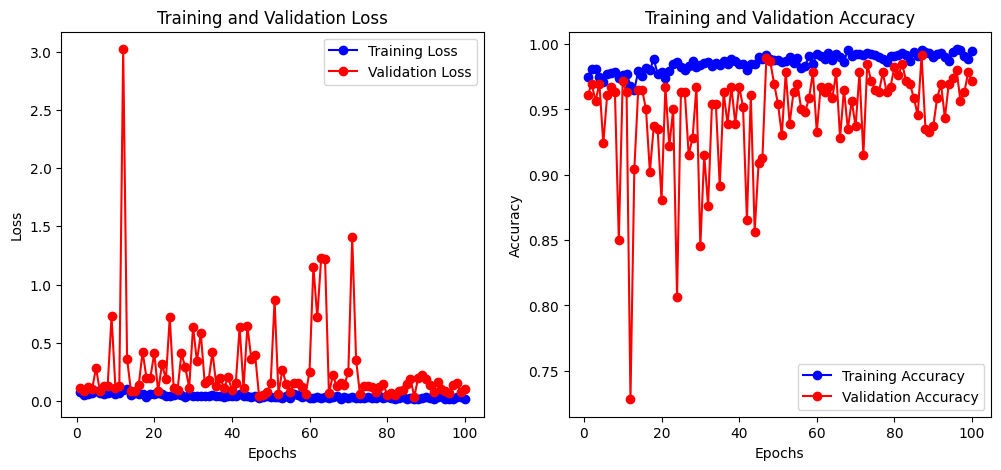

In [12]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss Graph
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot
plot_training_history(history)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Test Accuracy: 0.9804
Precision: 0.9810
Recall: 0.9804
F1 Score: 0.9805


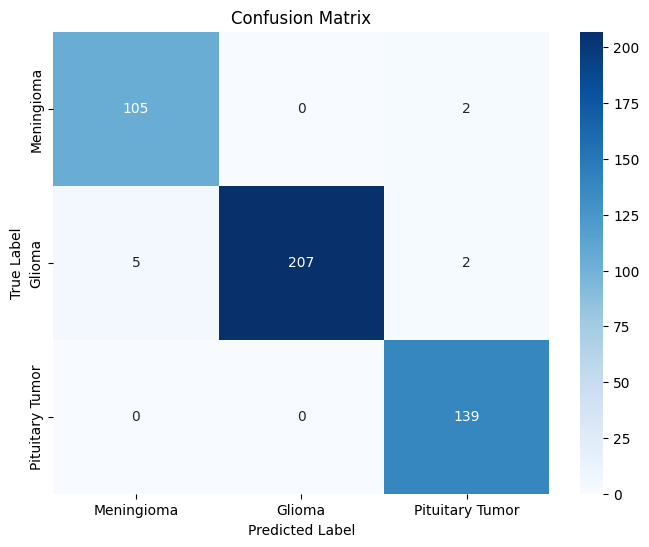

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Ensure Y_test_labels is a 1D array of class indices
if len(Y_test_labels.shape) > 1 and Y_test_labels.shape[1] > 1:
    y_true = np.argmax(Y_test_labels, axis=1)  # Convert one-hot labels to class indices
else:
    y_true = Y_test_labels  # Already class indices

# Predict class probabilities
y_pred_probs = model.predict([X_test, X_test_seg])  # Predict using both inputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Meningioma", "Glioma", "Pituitary Tumor"], 
            yticklabels=["Meningioma", "Glioma", "Pituitary Tumor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Meningioma", "Glioma", "Pituitary Tumor"], 
            yticklabels=["Meningioma", "Glioma", "Pituitary Tumor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


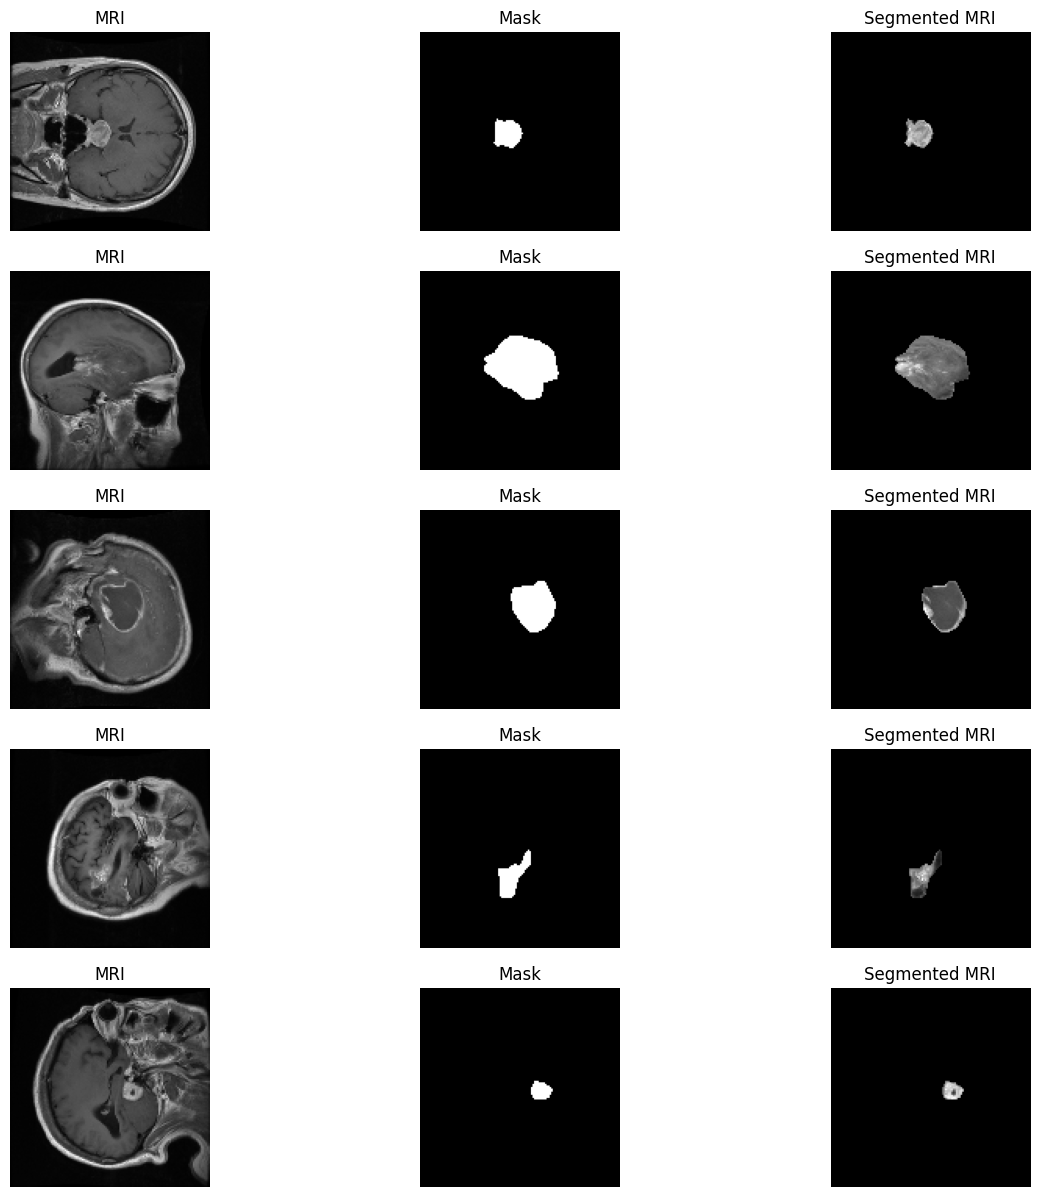

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to Apply Uniform Augmentation
def augment(mri, mask, seg):
    """ Apply the same random transformations to MRI, mask, and segmented images. """
    
    # Generate a single set of random transformations
    flip_lr = tf.random.uniform([]) > 0.5  # Randomly decide whether to flip left-right
    flip_ud = tf.random.uniform([]) > 0.5  # Randomly decide whether to flip up-down
    rotate_k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)  # Random rotation (0, 90, 180, 270 degrees)

    # Apply transformations uniformly
    if flip_lr:
        mri = tf.image.flip_left_right(mri)
        mask = tf.image.flip_left_right(mask)
        seg = tf.image.flip_left_right(seg)
        
    if flip_ud:
        mri = tf.image.flip_up_down(mri)
        mask = tf.image.flip_up_down(mask)
        seg = tf.image.flip_up_down(seg)

    mri = tf.image.rot90(mri, k=rotate_k)
    mask = tf.image.rot90(mask, k=rotate_k)
    seg = tf.image.rot90(seg, k=rotate_k)

    return mri, mask, seg

# Convert Numpy Arrays to TensorFlow Dataset
def create_dataset(X, Y_mask, X_seg, augment_times=5):
    """ Create a dataset with multiple augmented copies for each image """
    dataset = tf.data.Dataset.from_tensor_slices((X, Y_mask, X_seg))

    # Apply augmentation multiple times to generate more images
    dataset = dataset.flat_map(lambda mri, mask, seg:
                               tf.data.Dataset.from_tensors((mri, mask, seg))
                               .repeat(augment_times))  # Augment each image multiple times

    # Ensure correct mapping
    dataset = dataset.map(lambda mri, mask, seg: augment(mri, mask, seg), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch the dataset correctly with all three outputs
    dataset = dataset.map(lambda mri, mask, seg: (mri, mask, seg))
    
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create Training Dataset with Augmentation
train_dataset = create_dataset(X_train, Y_train_mask, X_train_seg, augment_times=5)

# Function to Visualize Augmented Images
def visualize_augmentations(dataset, num_images=5):
    """ Plot augmented MRI, mask, and segmented images side by side """
    plt.figure(figsize=(15, num_images * 3))

    for i, (mri, mask, seg) in enumerate(dataset.take(num_images)):
        mri, mask, seg = mri.numpy(), mask.numpy(), seg.numpy()
        
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(mri[0, :, :, 0], cmap="gray")
        plt.axis("off")
        plt.title("MRI")
        
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(mask[0, :, :, 0], cmap="gray")
        plt.axis("off")
        plt.title("Mask")
        
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(seg[0, :, :, 0], cmap="gray")
        plt.axis("off")
        plt.title("Segmented MRI")

    plt.show()

# Display Augmented Images
visualize_augmentations(train_dataset)
